# 10.2 General Introduction to Simulations with SIXTE

As discussed in more detail in Sect. 1, SIXTE is a Monte Carlo based tool that can simulate observations of
astrophysical sources for a wide variety of different current and future X-ray astronomical satellites. A SIXTE
simulation consists of three steps:  
   1. Preparation of the input of the simulation, using so-called SIMPUT files (Sect. 2): In this step we define what is to be observed. Typically this will be a pointed observation of a field on the sky. In the most simple case, this field will only contain one point source, but the simulations also allow to take into account extended sources, time variability, or the simulation of large catalogues of astronomical sources that can contain millions of X-ray sources on the whole sky. Later examples in this and the following sections will present some of the more advanced features.  
   2. Running the simulation: In this step photons from all sources that are visible to the instrument are generated using a Monte Carlo algorithm (Sect. 3). These photons are then projected onto the focal plane of the instrument using a model of the instrumental optics (Sect. 4) where they are detected using one of the available instrumental models (Sect. 6).  
   3. Analyzing the simulation: The output of the previous step are one or multiple standard FITS event files whose structure follows X-ray astronomical standards as specified by NASA’s HEASARC. The output can therefore be analyzed using standard astronomical data analysis packages. SIXTE provides some tools that prepare standard data products such as spectra and images from event files, alternatively other tools that can read FITS event files can be used.  
   
Before we start in the next sections with more complicated examples, in the following we will illustrate how a
SIXTE simulation works using a simple observation of a point source.


In [123]:
# import some general packages

import subprocess
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import tempfile
from datetime import datetime
from subprocess import check_call, STDOUT

# Astropy
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

#XSPEC
from xspec import Xset, Plot, AllData, ModelManager, Spectrum, Model, AllModels, Fit

## 10.2.1 Step 0: SIXTE installation setup

In [124]:
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ.get("PFILES", "")

os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"

SIMPUT = os.environ.get("SIMPUT")
if not SIMPUT:
    raise EnvironmentError("SIMPUT environment variable is not set.")
    
SIXTE = os.environ.get("SIXTE")
if not SIXTE:
    raise EnvironmentError("SIXTE environment variable is not set.")


# Set the base name for the simulation files
base = "mcrab"

# Define the directory for XML files (specific to the Athena WFI instrument configuration)
xmldir = f"{SIXTE}/share/sixte/instruments/athena-wfi/wfi_wo_filter_B4C"

# Create the directory for the tutorial if it doesn't already exist
current_dir = os.getcwd()
dir = os.path.join(current_dir, "sixte_tutorial")
os.makedirs(dir, exist_ok=True)

print(f"Directory created at: {dir}")

Directory created at: /Users/jessicaplanelles/sixte_tutorial


## 10.2.2 Step 1: Preparing the SIMPUT file

### Create an xspec model and save it as mcrab.xcm

Power law spectrum: $\Gamma=2.05$ 

Unabsorbed Flux(2-10keV): $2.16 \times 10^{-11} \rm{erg\,cm^{-2}\,s^{-1}}$  

Foregroung absorption: $N_H=2\times 10^{21} \rm{cm^{-2}}$  

XSPEC model: phabs*pegpwrlw

In [125]:
base = "mcrab"
xcm = os.path.join(dir, f"{base}.xcm") # In the directory created before

AllModels.clear()
Xset.abund = "wilm"
Xset.cosmo = "70 0. 0.73"
Xset.xsect = "bcmc"

mcmod = Model("phabs*pegpwrlw")
mcmod.phabs.nH = 0.2
mcmod.pegpwrlw.PhoIndex = 2.05
mcmod.pegpwrlw.eMin = 2.0
mcmod.pegpwrlw.eMax = 10.0
mcmod.pegpwrlw.norm = 21.6

mcmod.show()

 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).
 Cross Section Table set to bcmc:  Balucinska-Church and McCammon, 1998

Model phabs<1>*pegpwrlw<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   pegpwrlw   PhoIndex            1.00000      +/-  0.0          
   3    2   pegpwrlw   eMin       keV      2.00000      frozen
   4    2   pegpwrlw   eMax       keV      10.0000      frozen
   5    2   pegpwrlw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Model phabs<1>*pegpwrlw<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    0.200000     +/-  0.0          
   2    2   pegpwrlw   PhoIndex 

In [126]:
# Get FLUX value to use in SIMPUTFILE run
AllModels.calcFlux("2. 10.")
simput_flux = AllModels(1).flux[0]
print("Simput Flux =", simput_flux)

Simput Flux = Model Flux 0.0033181 photons (2.1306e-11 ergs/cm^2/s) range (2.0000 - 10.000 keV)
 2.1306205888361613e-11


In [127]:
clobber = True
if os.path.exists(xcm) and clobber:
    os.remove(xcm)  # Remove the file if it exists and clobber is True
elif os.path.exists(xcm) and not clobber:
    raise Exception(f"Xspec file ({xcm}) already exists: it will not be overwritten")

In [128]:
# Save the model to the specified .xcm file path
Xset.save(xcm)
print(f"Model saved to {xcm}")

Model saved to /Users/jessicaplanelles/sixte_tutorial/mcrab.xcm


### <span style="color:blue">$\textbf{Exercise}$</span>:
#### Add a narrow Gaussian iron line at an energy of 6.4 keV with an equivalent width of 150 eV to the spectrum.

In [129]:
AllModels.clear()
AllData.clear()
mcmodG = Model("phabs*pegpwrlw + ga")
mcmodG.phabs.nH = 0.2
mcmodG.pegpwrlw.PhoIndex = 2.05
mcmodG.pegpwrlw.eMin = 2.
mcmodG.pegpwrlw.eMax = 10.
mcmodG.pegpwrlw.norm = 21.6
mcmodG.gaussian.LineE = 6.4
mcmodG.gaussian.Sigma = 0.001
mcmodG.gaussian.norm = 3.01e-5 ## modify this value as needed to get the 150eV equivalent width
mcmodG.show()
AllModels.eqwidth(3) # value is only stored if spectrum is loaded (which is not)



Model phabs<1>*pegpwrlw<2> + gaussian<3> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   pegpwrlw   PhoIndex            1.00000      +/-  0.0          
   3    2   pegpwrlw   eMin       keV      2.00000      frozen
   4    2   pegpwrlw   eMax       keV      10.0000      frozen
   5    2   pegpwrlw   norm                1.00000      +/-  0.0          
   6    3   gaussian   LineE      keV      6.50000      +/-  0.0          
   7    3   gaussian   Sigma      keV      0.100000     +/-  0.0          
   8    3   gaussian   norm                1.00000      +/-  0.0          
________________________________________________________________________


Model phabs<1>*pegpwrlw<2> + gaussian<3> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    0.200000     +/-  0.0          
   2    2   pegpw

In [130]:
AllModels.calcFlux("2. 10.")
simput_flux = AllModels(1).flux[0]
print("Simput Flux=", simput_flux)

# Update the .xcm file
clobber = True
if os.path.exists(xcm) and clobber:
    os.remove(xcm)  
elif os.path.exists(xcm) and not clobber:
    raise Exception(f"Xspec file ({xcm}) already exists: it will not be overwritten")

# Save the model to the specified .xcm file path
Xset.save(xcm)
print(f"Model saved to {xcm}")

Simput Flux= Model Flux 0.0033482 photons (2.1615e-11 ergs/cm^2/s) range (2.0000 - 10.000 keV)
 2.1614895458730992e-11
Model saved to /Users/jessicaplanelles/sixte_tutorial/mcrab.xcm


### Create SIMPUT FILE for source (``simputfile``)

In [131]:
simputfile = os.path.join(dir, f"{base}.fits")
xcmfile = os.path.join(dir, f"{base}.xcm")

comm = (
    f"simputfile Simput={simputfile} Src_Name=first RA=0. Dec=0. srcFlux={simput_flux} "
    f"Elow=0.1 Eup=15. NBins=1000 Emin=2 Emax=10. XSPECFile={xcmfile} clobber=yes"
)

try:
    result = subprocess.run(comm, shell=True, check=True, capture_output=True, text=True)
    print("Simputfile created successfully.")
    print(result.stdout)  
except subprocess.CalledProcessError as e:
    print("Error creating simputfile.")
    print(e.stderr)

Simputfile created successfully.
finished successfully!


		XSPEC version: 12.14.1
	Build Date/Time: Sun Oct 13 18:44:41 2024


!XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

!XSPEC12>method leven 10 0.01

!XSPEC12>abund wilm
 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).

!XSPEC12>xsect bcmc
 Cross Section Table set to bcmc:  Balucinska-Church and McCammon, 1998

!XSPEC12>cosmo 70 0 0.73

!XSPEC12>xset delta 0.01
Parameter delta values for fits will now be 0.01 * parValue

!XSPEC12>systematic 0

 The default systematic error for models is set to 0


!XSPEC12>model  phabs*pegpwrlw + gaussian  ;              0.2      0.001          0          0     100000      1e+06  ;             2.05       0.01         -3         -2          9         10  ;                2      -0.01       -100       -1

### <span style="color:blue"> $\textbf{Exercise}$</span>: 
#### Generate a second SIMPUT file for our source, using the plPhoIndex, plFlux, and NH parameters rather than an xcm-file. Compare both SIMPUT-files using fv. **Note this step only works if you have ISIS installed**


In [132]:
simputfile = os.path.join(dir, f"{base}_wo-xcm.fits")

comm = (
    f"simputfile Simput={simputfile} Src_Name=first RA=0. Dec=0. srcFlux={simput_flux} Elow=0.1 Eup=15. "
    f"Emin=2 Emax=10. clobber=yes plPhoIndex=2.05 plFlux=21.6 NH=0.2"
)

try:
    env = os.environ.copy()
    env["HEADASNOQUERY"] = "true"
    result = subprocess.run(comm, shell=True, check=True, capture_output=True, text=True, env=env)
    print("Simputfile created successfully.")
    print(result.stdout)  # Displays the command output if needed
except subprocess.CalledProcessError as e:
    print("Error creating simputfile.")
    print(e.stderr)  # Shows the error message

Error creating simputfile.
sh: isis: command not found
ERROR: Operation not permitted
Task simputspec 0.12 terminating with status 1
ERROR: Operation not permitted
Task simputfile 0.21 terminating with status 1



## 10.2.3 An aside: Inspecting FITS-files with (HEASOFT)/Astropy tools


In [133]:
simputfile = os.path.join(dir, f"{base}.fits")
f = fits.open(simputfile)
f.info()
f[1].columns.names
f.close()

Filename: /Users/jessicaplanelles/sixte_tutorial/mcrab.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SRC_CAT       1 BinTableHDU     44   1R x 12C   [J, 32A, D, D, E, E, E, E, E, 32A, 32A, 32A]   
  2  SPECTRUM      1 BinTableHDU     21   1R x 3C   [1PE(1000), 1PE(1000), 48A]   


## 10.2.4 Step2: Running the simulation

### Simulate with WFI one large chip (``runsixt``)

In [134]:
xmldir = f"{SIXTE}/share/sixte/instruments/athena-wfi/wfi_wo_filter"
xml = f"{xmldir}/ld_wfi_ff_large.xml"

simputfile = os.path.join(dir, f"{base}.fits")
evtfile = os.path.join(dir, f"sim_evt_{base}.fits")

comm = (
    f"runsixt XMLFile={xml} RA=0. Dec=0. Prefix='' Simput={simputfile} "
    f"EvtFile={evtfile} Exposure=1000 clobber=yes"
)

try:
    print("Simulating source with WFI instrument...")
    result = subprocess.run(comm, shell=True, check=True, capture_output=True, text=True)
    print("Simulation completed successfully.")
    print(result.stdout)

except subprocess.CalledProcessError as e:
    print("Error in the simulation with WFI instrument.")
    print(e.stderr)

Simulating source with WFI instrument...
Simulation completed successfully.
SIXTE version 2.7.2
initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_v20230523.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

InconsistentKeywordValues: First channel differs between MATRIX (1) and EBOUNDS (0) extensions.

=== End of RMF validity check report ===

open Pha2Pi file '/Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pha2pi_v20230609.fits' ...
load source catalog from file '/Users/jessicaplanelles/sixte_tutorial/mcrab.fits' ...
try to load all spectra ('/Users/jessicaplanelles/sixte_tutorial/mcrab.fits[SPECTRUM,1]') into cache ...
open event file 'raw.fits' ...
open event file '/Users/jessicaplanelles/sixte_tutorial/sim_evt_mcrab.fits' ...
start simulation ...

0 %
*** Warni

### <span style="color:blue">$\textbf{Exercise}$</span>: 
#### Modify your SIMPUT-file to cover the full energy range of the ARF. 
##### Note that you actually have to go slightly past the limits listed in the ARF because the energy grid of the spectrum is generated at the midpoints of the bins from Elow to Eup.


In [135]:
simputfile = os.path.join(dir, f"{base}.fits")

comm_simputfile = (
    f"simputfile Simput={simputfile} Src_Name=first RA=0. Dec=0. srcFlux={simput_flux} "
    f"Elow=0.01 Eup=20. NBins=1000 Emin=2 Emax=10. XSPECFile={xcmfile} clobber=yes"
)

try:
    print("Creating simputfile...")
    result = subprocess.run(comm_simputfile, shell=True, check=True, capture_output=True, text=True)
    print("Simputfile created successfully.")
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("Error creating simputfile.")
    print(e.stderr)


Creating simputfile...
Simputfile created successfully.
finished successfully!


		XSPEC version: 12.14.1
	Build Date/Time: Sun Oct 13 18:44:41 2024


!XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

!XSPEC12>method leven 10 0.01

!XSPEC12>abund wilm
 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).

!XSPEC12>xsect bcmc
 Cross Section Table set to bcmc:  Balucinska-Church and McCammon, 1998

!XSPEC12>cosmo 70 0 0.73

!XSPEC12>xset delta 0.01
Parameter delta values for fits will now be 0.01 * parValue

!XSPEC12>systematic 0

 The default systematic error for models is set to 0


!XSPEC12>model  phabs*pegpwrlw + gaussian  ;              0.2      0.001          0          0     100000      1e+06  ;             2.05       0.01         -3         -2          9         10  ;                2      -0

In [136]:
# Run again the simulation
evtfile = os.path.join(dir,f"sim_evt_{base}.fits")

comm_simulation = (
    f"runsixt XMLFile={xml} RA=0. Dec=0. Prefix='' Simput={simputfile} "
    f"EvtFile={evtfile} Exposure=1000 clobber=yes"
)

try:
    print("Simulating source with WFI instrument...")
    result = subprocess.run(comm_simulation, shell=True, check=True, capture_output=True, text=True)
    print("Simulation completed successfully.")
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("Error in the simulation with WFI instrument.")
    print(e.stderr)

Simulating source with WFI instrument...
Simulation completed successfully.
SIXTE version 2.7.2
initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_v20230523.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

InconsistentKeywordValues: First channel differs between MATRIX (1) and EBOUNDS (0) extensions.

=== End of RMF validity check report ===

open Pha2Pi file '/Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pha2pi_v20230609.fits' ...
load source catalog from file '/Users/jessicaplanelles/sixte_tutorial/mcrab.fits' ...
try to load all spectra ('/Users/jessicaplanelles/sixte_tutorial/mcrab.fits[SPECTRUM,1]') into cache ...
open event file 'raw.fits' ...
open event file '/Users/jessicaplanelles/sixte_tutorial/sim_evt_mcrab.fits' ...
start simulation ...

0 %
1 %
2 %
3

## 10.2.5 Step 3: Analyzing the simulation (``imgev`` and ``makespec``)

### <span style="color:blue">$\textbf{Exercise}$</span>: 
#### Take a look at the structure of the event file. How many events were simulated? Speculate on the meaning of the individual columns in the event file 

In [137]:
evtfile = os.path.join(dir,f"sim_evt_{base}.fits")
f = fits.open(evtfile)
f.info()

# events
data = f["EVENTS"].data
nevents = data.shape[0]
print("\nNumber of simulated events:{}\n".format(nevents))

# columns 
print("Columns in event file:")
f[1].columns.names

Filename: /Users/jessicaplanelles/sixte_tutorial/sim_evt_mcrab.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   ()      
  1  EVENTS        1 BinTableHDU    121   88583R x 16C   [D, J, J, J, E, I, I, D, D, 2J, 2J, I, J, I, 9E, 9J]   
  2  STDGTI        1 BinTableHDU     25   1R x 2C   [D, D]   

Number of simulated events:88583

Columns in event file:


['TIME',
 'FRAME',
 'PHA',
 'PI',
 'SIGNAL',
 'RAWX',
 'RAWY',
 'RA',
 'DEC',
 'PH_ID',
 'SRC_ID',
 'TYPE',
 'NPIXELS',
 'PILEUP',
 'SIGNALS',
 'PHAS']

In [138]:
# close event file
f.close()

### Create an image (`imgev`)

In [139]:
# create image
evtfile = os.path.join(dir, f"sim_evt_{base}.fits")
imgfile = os.path.join(dir, f"img_{base}.fits")

comm_create_image = (
    f"imgev EvtFile={evtfile} Image={imgfile} CoordinateSystem=0 Projection=TAN NAXIS1=512 NAXIS2=512 "
    f"CUNIT1=deg CUNIT2=deg CRVAL1=0.0 CRVAL2=0.0 CRPIX1=256.5 CRPIX2=256.5 CDELT1=-6.207043e-04 "
    f"CDELT2=6.207043e-04 history=true clobber=yes"
)

try:
    print("Creating WFI image...")
    result = subprocess.run(comm_create_image, shell=True, check=True, capture_output=True, text=True)
    print("Image created successfully.")
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("Error creating WFI image.")
    print(e.stderr)


Creating WFI image...
Image created successfully.
initialize ...
open event file '/Users/jessicaplanelles/sixte_tutorial/sim_evt_mcrab.fits' ...
finished successfully!




Text(0.5, 1.0, 'Central source zoom')

<Figure size 800x600 with 0 Axes>

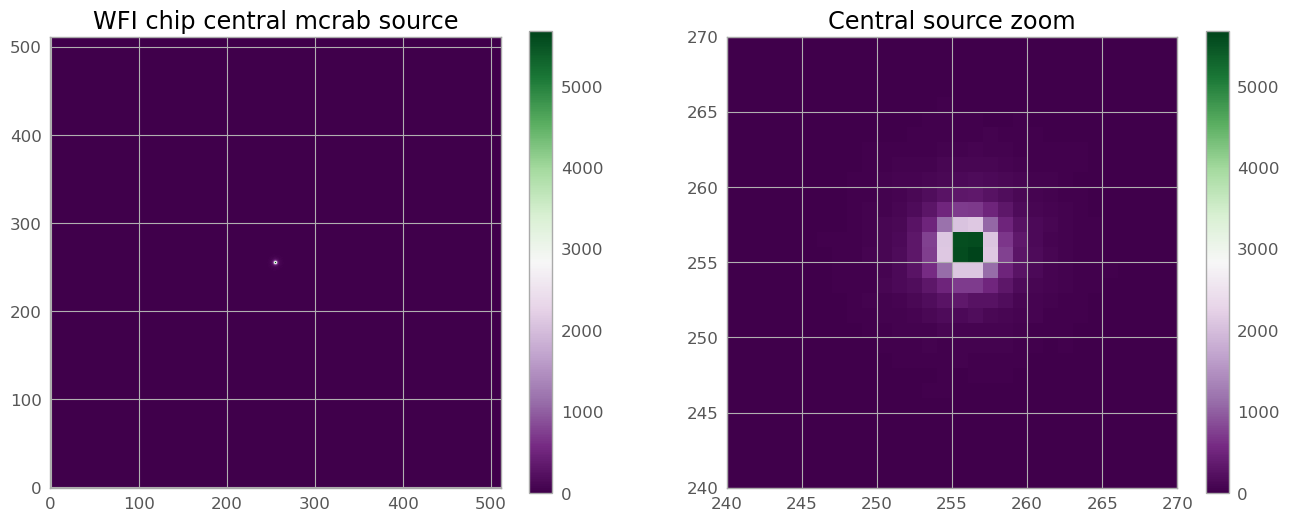

In [140]:
# Plot image
plt.clf()

plt.rcParams['axes.grid'] = True
image_data = fits.getdata(imgfile, ext=0)
fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
axs = _axs.flatten()
cmap = plt.cm.PRGn

# Left plot
im = axs[0].imshow(image_data, cmap=cmap, origin="lower")
fig.colorbar(im,ax=axs[0])

# Zoomed plot
im = axs[1].imshow(image_data[240:270, 240:270], extent=[240,270, 240,270], cmap=cmap, origin="lower")
fig.colorbar(im,ax=axs[1])

# Titles
axs[0].set_title("WFI chip central mcrab source")
axs[1].set_title("Central source zoom")


### Create an spectrum (`makespec`)

In [141]:
evtfile = os.path.join(dir, f"sim_evt_{base}.fits")
specfile = os.path.join(dir, f"spec_{base}.pha")

comm_create_spectrum = (
    f"makespec EvtFile={evtfile} Spectrum={specfile} clobber=yes RSPPath={xmldir} "
    f"EventFilter='(RA>359.95 || RA<0.05) && Dec>-0.05 && Dec<+0.05'"
)

try:
    print("Creating spectrum with WFI...")
    result = subprocess.run(comm_create_spectrum, shell=True, check=True, capture_output=True, text=True)
    print("Spectrum created successfully.")
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("Error creating WFI spectrum.")
    print(e.stderr)

Creating spectrum with WFI...
Spectrum created successfully.
initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

InconsistentKeywordValues: First channel differs between MATRIX (1) and EBOUNDS (0) extensions.

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!




### <span style="color:blue">$\textbf{Exercise}$</span>: 
#### Obtain the names of the the response matrix and the ancilliary response matrix (the “RMF” and the “ARF”). These names can be obtained by looking at the values of the RESPFILE and ANCRFILE keywords


In [142]:
specfile = os.path.join(dir, f"spec_{base}.pha")

with fits.open(specfile) as f:
    print("RESPFILE:", f[1].header.get("RESPFILE", "No RESPFILE"))
    print("ANCRFILE:", f[1].header.get("ANCRFILE", "No ANCRFILE"))

RESPFILE: /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf
ANCRFILE: /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_13rows_wo_filter_LDA_v20240209.arf


### Analyze the spectrum (PyXSPEC)

#### 1) fit spectrum in XSPEC


1 spectrum  in use
 
Spectral Data File: /Users/jessicaplanelles/sixte_tutorial/spec_mcrab.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.370e+01 +/- 2.893e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-1498
  Telescope: Athena Instrument: WFI  Channel Type: PI
  Exposure Time: 1000 sec
 Using fit statistic: chi
 Using Response (RMF) File            /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf for Source 1
 Using Auxiliary Response (ARF) File  /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_13rows_wo_filter_LDA_v20240209.arf



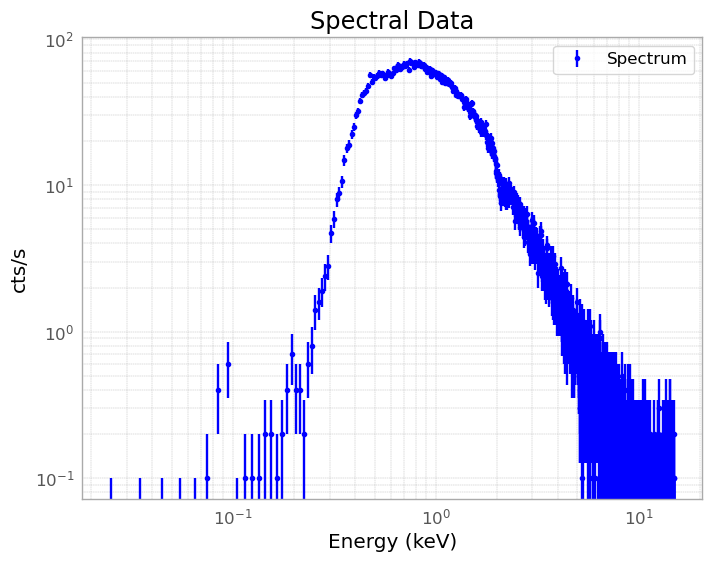

In [143]:
Plot.device = '/null'
AllData.clear()
AllModels.clear()
s0 = Spectrum(os.path.join(dir, f"spec_{base}.pha"))
Plot.device = "/null" # Desactiva la visualización en XSPEC
Plot.xAxis = "keV"
Plot('data')

energies = Plot.x()
counts = Plot.y()
errors = Plot.yErr()

plt.errorbar(energies, counts, yerr=errors, fmt='o', label="Spectrum", color='blue', markersize=3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy (keV)")
plt.ylabel("cts/s")
plt.title("Spectral Data")
plt.legend()
plt.grid(True, which="both", linestyle="--", lw=0.3)
plt.show()

#### 2) ignore energy bands where signal to noise ratio is small

In [144]:
# As there are bins with zero variance: ignore energy bands where signal to noise ratio is small
s0.ignore("**-0.3")
s0.ignore("4.0-**")
Plot('ldata')

    28 channels (1-28) ignored in spectrum #     1

  1101 channels (398-1498) ignored in spectrum #     1



#### 3) Define an absorbed power law model

In [145]:
m0 = Model("phabs*pow")


Model phabs<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   3    2   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              1.206620e+09     using 369 bins.

Test statistic : Chi-Squared              1.206620e+09     using 369 bins.
 Null hypothesis probability of 0.000000e+00 with 366 degrees of freedom
 Current data and model not fit yet.


#### 4) rebin spectral data

In [146]:
comm = f"grppha infile={specfile} outfile={binspec} clobber=yes comm='group min 20 & exit'"
try:
    print("Rebinning spectrum...")
    result = subprocess.run(comm, check=True, capture_output=True, text=True, shell=True)
    print("STDOUT:", result.stdout)
    print("STDERR:", result.stderr)
    
    if os.path.exists(binspec):
        print("Rebinning completed successfully.")
        print(f"Output file saved as: {binspec}")
    else:
        print("Error: The output file was not created.")
except subprocess.CalledProcessError as e:
    print("Error in rebinning spectrum:")
    print("STDOUT:", e.stdout)
    print("STDERR:", e.stderr)

Rebinning spectrum...
STDOUT:  
  -------------------------
  MANDATORY KEYWORDS/VALUES
  -------------------------
  --------------------------------------------------------------------
  --------------------------------------------------------------------
  EXTNAME   - SPECTRUM        Name of this BINTABLE
  TELESCOP  - Athena          Mission/Satellite name
  INSTRUME  - WFI             Instrument/Detector
  FILTER    - NONE            Instrument filter in use
  EXPOSURE  - 1000.0          Integration time (in secs) of PHA data
  AREASCAL  - 1.0000          Area scaling factor
  BACKSCAL  - 1.0000          Background scaling factor
  BACKFILE  - NONE            Associated background file
  CORRSCAL  - 0.0000          Correlation scaling factor
  CORRFILE  - NONE            Associated correlation file
  RESPFILE  - /Users/jessicaplanelles/simput4/share/sixte/instrument...
  ANCRFILE  - /Users/jessicaplanelles/simput4/share/sixte/instrument...
  POISSERR  - TRUE            Whether Poi

### <span style="color:blue">$\textbf{Exercise}$</span>: 
#### Load rebinned PHA-file into XSPEC and fit an absorbed power-law to the 0.3-4 keV band


In [147]:
binspec = os.path.join(dir, f"spec_{base}_rebin.pha")

with fits.open(binspec) as f:
    print("RESPFILE:", f[1].header.get("RESPFILE", "No RESPFILE"))
    print("ANCRFILE:", f[1].header.get("ANCRFILE", "No ANCRFILE"))

RESPFILE: /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf
ANCRFILE: /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_13rows_wo_filter_LDA_v20240209.arf



1 spectrum  in use
 
Spectral Data File: /Users/jessicaplanelles/sixte_tutorial/spec_mcrab_rebin.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.370e+01 +/- 2.893e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-508
  Telescope: Athena Instrument: WFI  Channel Type: PI
  Exposure Time: 1000 sec
 Using fit statistic: chi
 Using Response (RMF) File            /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf for Source 1
 Using Auxiliary Response (ARF) File  /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_13rows_wo_filter_LDA_v20240209.arf


Model phabs<1>*pegpwrlw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   pegpwrlw   PhoIndex            1.00000      +/-  0.0          
   3    2   pegpwrlw   eMin       keV      2.000

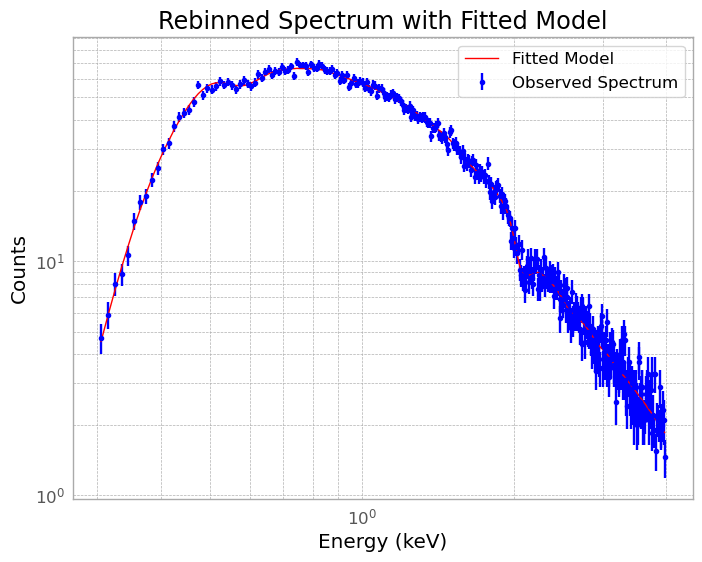

In [148]:
AllData.clear()
AllModels.clear()

s1 = Spectrum(binspec)
m0 = Model("phabs*pegpwrlw")

s1.ignore("**-0.3")
s1.ignore("4.0-**")

Fit.perform()

Plot.device = "/null"  
Plot("ldata")

energies = Plot.x()      
counts = Plot.y()            
errors = Plot.yErr()       
model_counts = Plot.model()   

plt.errorbar(energies, counts, yerr=errors, fmt='o', label="Observed Spectrum", color='blue', markersize=3)
plt.plot(energies, model_counts, label="Fitted Model", color='red', linewidth=1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Rebinned Spectrum with Fitted Model")
plt.legend()
plt.grid(True, which="both", linestyle="--", lw=0.5)
plt.show()

In [149]:
print(f"nH fit={m0.phabs.nH.values[0]:.3f}")
print(f"Gamma fit={m0.pegpwrlw.PhoIndex.values[0]:.3f}")

nH fit=0.203
Gamma fit=2.056


#### 5) check PILEUP

In [150]:
# check PILEUP as the cause for spectral distortion (G~1.8 instead of G~2)
evtfile = os.path.join(dir, f"sim_evt_{base}.fits")
f = fits.open(evtfile)
PILEUP = f[1].data["PILEUP"]
print("The sum of PILEUP column is                  {}".format(np.sum(PILEUP)))
print("The mean of PILEUP column is                 {}".format(PILEUP.mean()))
print("The standard deviation of PILEUP column is   {}".format(PILEUP.std()))
print("The minimum of PILEUP column is              {}".format(PILEUP.min()))
print("The maximum of PILEUP column is              {}".format(PILEUP.max()))
print("The number of points used in calculation is  {}".format(len(PILEUP)))

The sum of PILEUP column is                  505
The mean of PILEUP column is                 0.005700868112391768
The standard deviation of PILEUP column is   0.07528856629765825
The minimum of PILEUP column is              0
The maximum of PILEUP column is              1
The number of points used in calculation is  88583


### <span style="color:blue">$\textbf{Exercise}$</span>:  
#### change the pointing direction of the instrument away from the source in steps of 4' in right ascension and declination simultaneously. Take a look at the images of the source and the source count rate. What do you observe?

********************************
Image for offset=0 arcmin
********************************
Running simulation...
SIXTE version 2.7.2
initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_v20230523.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

InconsistentKeywordValues: First channel differs between MATRIX (1) and EBOUNDS (0) extensions.

=== End of RMF validity check report ===

open Pha2Pi file '/Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pha2pi_v20230609.fits' ...
load source catalog from file '/Users/jessicaplanelles/sixte_tutorial/mcrab.fits' ...
try to load all spectra ('/Users/jessicaplanelles/sixte_tutorial/mcrab.fits[SPECTRUM,1]') into cache ...
open event file 'raw.fits' ...
open event file '/Users/jessicaplanelles/sixte_tutorial/sim_evt_mcrab_dec0.fi

<Figure size 800x600 with 0 Axes>

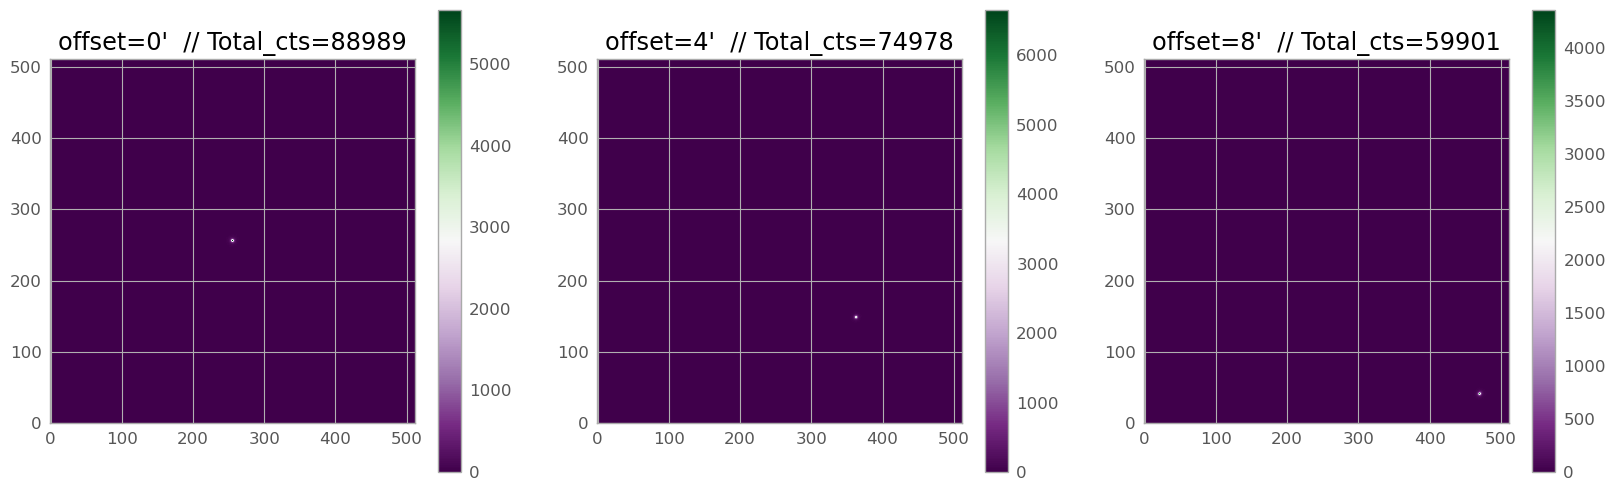

In [151]:
plt.rcParams['axes.grid'] = True 

noffs = 3  # Number of offsets (in steps of 4 arcmin)
xml = f"{xmldir}/ld_wfi_ff_large.xml"

simputfile = os.path.join(dir, f"{base}.fits")

plt.clf()
fig, _axs = plt.subplots(nrows=1, ncols=noffs, figsize=(20, 6))
axs = _axs.flatten()

cmap = plt.cm.PRGn  # Define color map once outside the loop

# Plotting 3 images of the source with the telescope moved away 4' and 8'
for ioff in range(0, noffs * 4, 4):
    print("********************************")
    print(f"Image for offset={ioff} arcmin")
    print("********************************")
    
    i = ioff // 4  # Corrected index calculation
    base_dec = f"mcrab_dec{ioff}"
    ra_off = ioff / 60
    dec_off = ioff / 60.0 
    expos = 1000
    simputfile_dec = os.path.join(dir, f"{base_dec}.simput")
    
    evtfile_dec = os.path.join(dir, f"sim_evt_{base_dec}.fits")
    comm_simulation = [
        "runsixt",
        f"XMLFile={xml}",
        f"RA={ra_off}",
        f"Dec={dec_off}",
        "Prefix=",
        f"Simput={simputfile}",
        f"EvtFile={evtfile_dec}",
        f"Exposure={expos}",
        "clobber=yes"
    ]
    
    try:
        print("Running simulation...")
        subprocess.run(comm_simulation, check=True)
    except subprocess.CalledProcessError as e:
        print("Error in running simulation:")
        print(e)
        continue
    
    # Create image
    imgfile_dec = os.path.join(dir, f"img_{base_dec}.fits")
    comm_image = [
        "imgev",
        f"EvtFile={evtfile_dec}",
        f"Image={imgfile_dec}",
        "CoordinateSystem=0",
        "Projection=TAN",
        "NAXIS1=512",
        "NAXIS2=512",
        "CUNIT1=deg",
        "CUNIT2=deg",
        f"CRVAL1={ra_off}",
        f"CRVAL2={dec_off}",
        "CRPIX1=256.5",
        "CRPIX2=256.5",
        "clobber=yes",
        "CDELT1=-6.207043e-04",
        "CDELT2=6.207043e-04"
    ]
    
    try:
        print("Creating image...")
        subprocess.run(comm_image, check=True)
    except subprocess.CalledProcessError as e:
        print("Error in creating image:")
        print(e)
        continue
    
    image_data = fits.getdata(imgfile_dec, ext=0)

    # Display the image in a subplot
    im = axs[i].imshow(image_data, cmap=cmap, origin="lower")
    fig.colorbar(im, ax=axs[i])
    tit = f"offset={ioff}'  // Total_cts={np.sum(image_data)}"
    axs[i].set_title(tit)

plt.show()



### <span style="color:blue">$\textbf{Exercise}$</span>:  
#### a) In this exercise we continue studying the effects that bright sources have on the measurement process more. Using the Crab-like spectrum defined before, increase the source flux by a factor of 10, 100, and 1000 and redo the WFI simulation. Why can you prepare the simulation using *mcrab.fits* and `fv`, and without running simputfile?



In [152]:
# Re-using the XSPEC spectra file and thus, the SIMPUT file
simputfile = os.path.join(dir, f"{base}.fits")
flux_ratio = [1, 10, 100, 1000]
nfactors = len(flux_ratio)

# Create new simput files by modifying the flux from the original simput file
for factor in flux_ratio:
    new_simputfile = os.path.join(dir, f"{base}_factor{factor}.fits")
    with fits.open(simputfile, mode='readonly') as f:
        initial_flux = f["SRC_CAT"].data["FLUX"]
        f["SRC_CAT"].data["FLUX"] = factor * initial_flux
        f.writeto(new_simputfile, overwrite=True)



In [165]:
# Define parameters for the simulation
xml = os.path.join(xmldir, "ld_wfi_ff_large.xml")
expos = 1000

# Loop through factors and run the simulation for each flux factor
for factor in flux_ratio:
    new_simputfile = os.path.join(dir, f"{base}_factor{factor}.fits")
    new_evtfile = os.path.join(dir, f"sim_evt_{base}_factor{factor}.fits")
    
    comm = [
        "runsixt",
        f"XMLFile={xml}",
        "RA=0.",
        "Dec=0.",
        f"Simput={new_simputfile}",
        f"EvtFile={new_evtfile}",
        f"Exposure={expos}",
        "clobber=yes"
    ]
    
    try:
        print(f"Running simulation for flux factor {factor}...")
        result = subprocess.run(comm, check=True, capture_output=True, text=True)
        print(f"Simulation for flux factor {factor} completed.")
        print("Output:", result.stdout)
        if result.stderr:
            print("Warnings/Errors:", result.stderr)
    except subprocess.CalledProcessError as e:
        print(f"An error occurred during simulation for flux factor {factor}: {e}")
        print("Error details:", e.stderr)


Running simulation for flux factor 1...
Simulation for flux factor 1 completed.
Output: SIXTE version 2.7.2
initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_v20230523.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

InconsistentKeywordValues: First channel differs between MATRIX (1) and EBOUNDS (0) extensions.

=== End of RMF validity check report ===

open Pha2Pi file '/Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pha2pi_v20230609.fits' ...
load source catalog from file '/Users/jessicaplanelles/sixte_tutorial/mcrab_factor1.fits' ...
try to load all spectra ('/Users/jessicaplanelles/sixte_tutorial/mcrab_factor1.fits[SPECTRUM,1]') into cache ...
open event file 'raw.fits' ...
open event file '/Users/jessicaplanelles/sixte_tutorial/sim_evt_mcrab_factor1.fits' ...

#### b) Calculate the count rates of the simulations by looking at the number of events in the file. What do you notice? Take a look at the X-ray spectrum of the 2nd brightest simulation and compare the observed photon spectrum with your input photon index. 

In [166]:
nevents = np.zeros(len(flux_ratio))  # Ensure array size matches flux_ratio length
for i, factor in enumerate(flux_ratio):
    new_evtfile = os.path.join(dir, f"sim_evt_{base}_factor{factor}.fits")
    
    # Open the file and extract the number of events
    with fits.open(new_evtfile) as f:
        nevents[i] = f[1].header["NAXIS2"]
    
    # Calculate and print the count rate
    count_rate = nevents[i] / expos  # Assuming 'expos' is defined elsewhere
    print(f"Count rate for flux factor {factor}: {count_rate} cts/s")

Count rate for flux factor 1: 88.629 cts/s
Count rate for flux factor 10: 696.631 cts/s
Count rate for flux factor 100: 3000.931 cts/s
Count rate for flux factor 1000: 14126.588 cts/s


In [192]:
factor = flux_ratio[1]
new_specfile = os.path.join(dir, f"sim_evt_{base}_factor{factor}.pha")
new_evtfile = os.path.join(dir, f"sim_evt_{base}_factor{factor}.fits")

sixte_bin = os.environ.get("SIXTE", "")
if not sixte_bin:
    print("Error: SIXTE environment variable is not set.")
else:
    sixte_bin_path = os.path.join(sixte_bin, "bin", "makespec")
    
    env = os.environ.copy()
    env["HEADASNOQUERY"] = "true"
    
    comm = [
        sixte_bin_path,
        f"EvtFile={new_evtfile}",
        f"Spectrum={new_specfile}",
        f"RSPPath={xmldir}",
        "clobber=yes",
        'EventFilter=(RA>299.58 && RA<299.60) && (Dec>35.19 && Dec<35.21)'
    ]

    try:
        subprocess.run(comm, check=True, capture_output=True, text=True, env=env)
        print(f"Spectrum file generated successfully: {new_specfile}")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred while running makespec: {e}")
        print("Error details:", e.stderr)

Spectrum file generated successfully: /Users/jessicaplanelles/sixte_tutorial/sim_evt_mcrab_factor10.pha


In [193]:
# strip path in keywords to avoid very long values
f = fits.open(new_specfile, 'update')
f[1].header['RESPFILE'] = rmf
f[1].header['ANCRFILE'] = arf
f.close()

In [194]:
# rebin spectrum
new_binspec = os.path.join(dir, f"spec_{base}_factor{factor}_rebin.pha")

comm = f"grppha infile={new_specfile} outfile={new_binspec} clobber=yes comm='group min 10 & exit'"
try:
    print("Rebinning spectrum...")
    result = subprocess.run(comm, check=True, capture_output=True, text=True, shell=True)
    print("STDOUT:", result.stdout)
    print("STDERR:", result.stderr)
    
    if os.path.exists(binspec):
        print("Rebinning completed successfully.")
        print(f"Output file saved as: {binspec}")
    else:
        print("Error: The output file was not created.")
except subprocess.CalledProcessError as e:
    print("Error in rebinning spectrum:")
    print("STDOUT:", e.stdout)
    print("STDERR:", e.stderr)
    

Rebinning spectrum...
STDOUT:  
  -------------------------
  MANDATORY KEYWORDS/VALUES
  -------------------------
  --------------------------------------------------------------------
  --------------------------------------------------------------------
  EXTNAME   - SPECTRUM        Name of this BINTABLE
  TELESCOP  - Athena          Mission/Satellite name
  INSTRUME  - WFI             Instrument/Detector
  FILTER    - NONE            Instrument filter in use
  EXPOSURE  - 1000.0          Integration time (in secs) of PHA data
  AREASCAL  - 1.0000          Area scaling factor
  BACKSCAL  - 1.0000          Background scaling factor
  BACKFILE  - NONE            Associated background file
  CORRSCAL  - 0.0000          Correlation scaling factor
  CORRFILE  - NONE            Associated correlation file
  RESPFILE  - /Users/jessicaplanelles/simput4/share/sixte/instrument...
  ANCRFILE  - /Users/jessicaplanelles/simput4/share/sixte/instrument...
  POISSERR  - TRUE            Whether Poi

In [208]:
Plot.device = '/null'
AllData.clear()
AllModels.clear()
s1 = Spectrum(new_binspec)
m0 = Model("phabs*pegpwrlw")
s1.ignore("**-0.3")
s1.ignore("4.0-**")
Fit.perform()

Plot("ldata")
m0.show()
Plot.device = '/null'


1 spectrum  in use
 
Spectral Data File: spec_mcrab_factor10_rebin.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  0.000e+00 +/- 0.000e+00
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-1498
  Telescope: Athena Instrument: WFI  Channel Type: PI
  Exposure Time: 1000 sec
 Using fit statistic: chi
 Using Response (RMF) File            /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf for Source 1
 Using Auxiliary Response (ARF) File  /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_13rows_wo_filter_LDA_v20240209.arf


Model phabs<1>*pegpwrlw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   pegpwrlw   PhoIndex            1.00000      +/-  0.0          
   3    2   pegpwrlw   eMin       keV      2.00000      frozen
   4    2   pe

In [209]:
# Get spectral index
print(f"Gamma fit={m0.pegpwrlw.PhoIndex.values[0]:.3f}")

Gamma fit=1.000


### <span style="color:blue">$\textbf{Exercise}$</span>:  
#### To get a better feeling for what is going on, plot the value of the FITS keywords NVALID, NPVALID, NINVALID, and NPINVALI as a function of the input flux. Why is the pile up fraction NPVALID/NVALID a good measure for the scientific quality of the data?

In [197]:
nvalid = np.zeros(nfactors)     # gives the total number of events that were classified as valid in the simulation
npvalid = np.zeros(nfactors)    # fraction of valid events caused by two or more photons (pileup)
ninvalid = np.zeros(nfactors)   # gives the total number of rejected events that were correctly classified as invalid during the simulation
npinvali = np.zeros(nfactors)   #  the fraction of these invalid events affected by pile up

for i in range(nfactors):
    factor = flux_ratio[i]
    new_evtfile = os.path.join(dir, f"sim_evt_{base}_factor{factor}.fits")
    
    # Save the parameters wanted of the event file in an empty list
    f = fits.open(new_evtfile)
    nvalid[i] = (f['EVENTS'].header['NVALID'])
    npvalid[i] = (f['EVENTS'].header['NPVALID'])
    ninvalid[i] = (f['EVENTS'].header['NINVALID'])
    npinvali[i] = (f['EVENTS'].header['NPINVALI'])

    data_quality = npvalid[i]/nvalid[i]
    print("###############################################################")
    print(f"Valid events: {nvalid[i]} of which {npvalid[i]} are piled-up")
    print(f"InValid events: {ninvalid[i]} of which {npinvali[i]} are piled-up")
    print(f"Data quality={data_quality:.3f}")
    print("###############################################################")
    f.close

print(f"NVALID:   {nvalid}")
print(f"NPVALID:  {npvalid}")
print(f"NINVALID: {ninvalid}")
print(f"NPINVALI: {npinvali}")

###############################################################
Valid events: 88629.0 of which 477.0 are piled-up
InValid events: 881.0 of which 713.0 are piled-up
Data quality=0.005
###############################################################
###############################################################
Valid events: 696631.0 of which 32877.0 are piled-up
InValid events: 54072.0 of which 53015.0 are piled-up
Data quality=0.047
###############################################################
###############################################################
Valid events: 3000931.0 of which 135457.0 are piled-up
InValid events: 657146.0 of which 651142.0 are piled-up
Data quality=0.045
###############################################################
###############################################################
Valid events: 14126588.0 of which 692477.0 are piled-up
InValid events: 1675828.0 of which 1647287.0 are piled-up
Data quality=0.049
############################################

Text(0, 0.5, 'Data Quality')

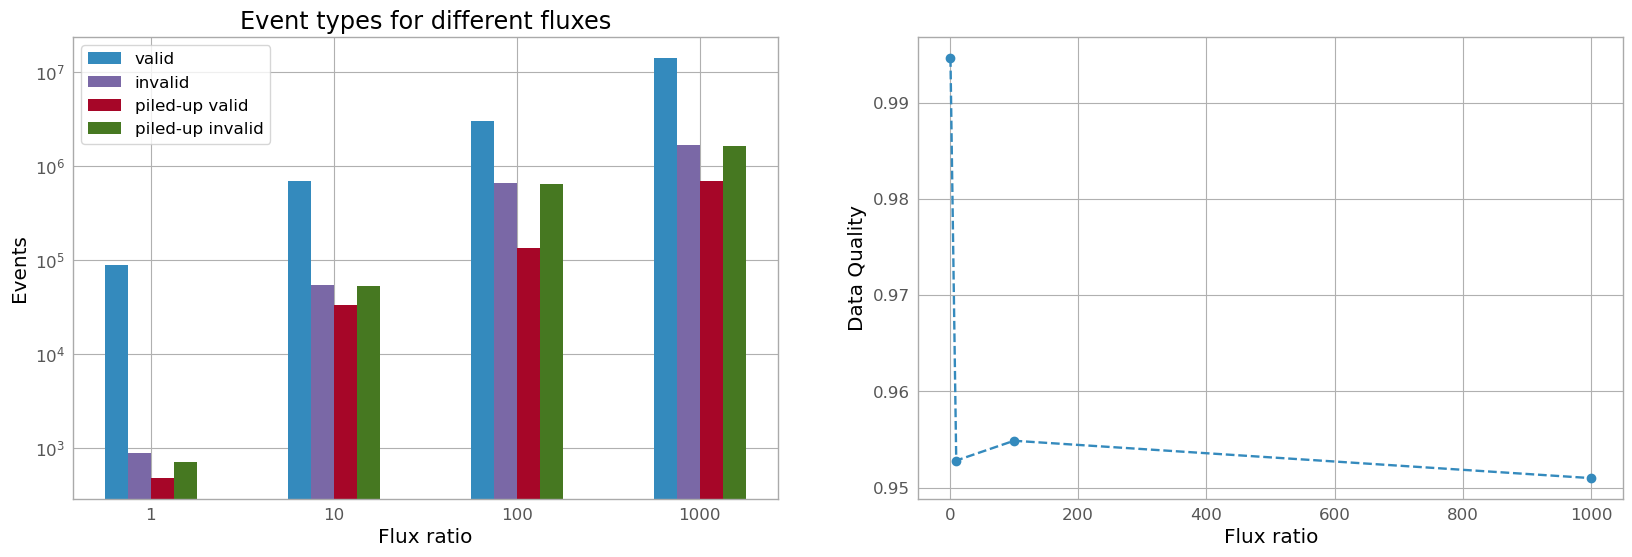

In [198]:
# Plot histogram of the data collected from the different simulations of the 4 fluxes.

fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
axs = _axs.flatten()
#flux_labels = ['1', '10', '100', '1000']
flux_labels = [str(a) for a in flux_ratio]
x = np.arange(len(flux_labels))
width = 0.25
axs[0].bar(x-0.75*width, nvalid, width/2, log=True, label="valid")
axs[0].bar(x-width/4, ninvalid, width/2, log=True, label="invalid")
axs[0].bar(x+width/4, npvalid, width/2, log=True,label="piled-up valid")
axs[0].bar(x+0.75*width, npinvali, width/2, log=True,label="piled-up invalid")
axs[0].set_xlabel("Flux ratio")
axs[0].set_ylabel('Events')
axs[0].set_title('Event types for different fluxes')
axs[0].set_xticks(x)
axs[0].set_xticklabels(flux_labels)
axs[0].legend()

data_quality = (1-npvalid/nvalid)

axs[1].plot(flux_ratio, data_quality, marker='o', linestyle='--')
axs[1].set_xlabel("Flux ratio")
axs[1].set_ylabel("Data Quality")

### <span style="color:blue">$\textbf{Exercise}$</span>:  

#### Generate a SIMPUT file with a harder spectral shape (e.g., Γ = 1.5) than our example source and has the same flux. Place the source at a position that is 10" away from our source. Merge both SIMPUT files with the simputmerge tool (use `plist` to learn about the parameters of this tool!). Then run a 5 ks simulation and study how well you can separate both sources.

    

In [199]:
# xspec file
AllModels.clear()
AllData.clear()
base_harder = "hardersrc"
xcm_harder = os.path.join(dir, f"{base_harder}.xcm")
mod_harder = Model("phabs*pegpwrlw")
mod_harder.phabs.nH = 0.2
mod_harder.pegpwrlw.PhoIndex = 1.5
mod_harder.pegpwrlw.eMin = 2.
mod_harder.pegpwrlw.eMax = 10.
mod_harder.pegpwrlw.norm = 21.6 # same unabsorbed 2-10 keV flux as initial mcrab source (see Section 10.2.2)
mod_harder.show()
AllModels.calcFlux("2. 10.")
simput_flux_harder = AllModels(1).flux[0]

clobber = True
# If clobber is true and the file exists, it will be removed before creating a new one.
if os.path.exists(xcm_harder):
    if clobber:
        os.remove(xcm_harder)
    else:
        raise Exception("Xspec file ({}) already exists: it will not be overwritten".format(xcm_harder)) 
Xset.save(xcm_harder)


Model phabs<1>*pegpwrlw<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   pegpwrlw   PhoIndex            1.00000      +/-  0.0          
   3    2   pegpwrlw   eMin       keV      2.00000      frozen
   4    2   pegpwrlw   eMax       keV      10.0000      frozen
   5    2   pegpwrlw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Model phabs<1>*pegpwrlw<2> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    0.200000     +/-  0.0          
   2    2   pegpwrlw   PhoIndex            1.50000      +/-  0.0          
   3    2   pegpwrlw   eMin       keV      2.00000      frozen
   4    2   pegpwrlw   eMax       keV      10.0000      frozen
   5    2   pegpwrlw   norm                21.6000      +/-  0.0     

In [200]:
# simputfile
simputfile10 = os.path.join(dir, f"{base_harder}_10.fits")
ra = 0.0
dec10 = 10.0 / 3600  # deg
Elow = 0.01  # to cover full range of ARF
Eup = 20  # to cover full range of ARF
Emin = 2
Emax = 10

# Command for creating the simput file
comm = [
    "simputfile",
    f"Simput={simputfile10}",
    "Src_Name=first",
    f"RA={ra}",
    f"Dec={dec10}",
    f"srcFlux={simput_flux_harder}",
    f"Elow={Elow}",
    f"Eup={Eup}",
    "NBins=1000",
    f"Emin={Emin}",
    f"Emax={Emax}",
    f"XSPECFile={xcm_harder}",
    "clobber=yes"
]

# Run the command with subprocess
try:
    print("Creating simput file...")
    subprocess.run(comm, check=True)
    print("Simput file created successfully.")
except subprocess.CalledProcessError as e:
    print(f"An error occurred while creating the simput file: {e}")

Creating simput file...
finished successfully!


		XSPEC version: 12.14.1
	Build Date/Time: Sun Oct 13 18:44:41 2024


!XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

!XSPEC12>method leven 10 0.01

!XSPEC12>abund wilm
 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).

!XSPEC12>xsect bcmc
 Cross Section Table set to bcmc:  Balucinska-Church and McCammon, 1998

!XSPEC12>cosmo 70 0 0.73

!XSPEC12>xset delta 0.01
Parameter delta values for fits will now be 0.01 * parValue

!XSPEC12>systematic 0

 The default systematic error for models is set to 0


!XSPEC12>model  phabs*pegpwrlw  ;              0.2      0.001          0          0     100000      1e+06  ;              1.5       0.01         -3         -2          9         10  ;                2      -0.01       -100       -100      1e+10      1

In [201]:
# Merge simput files
simput_merged10 = os.path.join(dir, f"{base}_{base_harder}_10_merged.fits")
comm_merge = [
    "simputmerge",
    f"Infile1={simputfile}",
    f"Infile2={simputfile10}",
    f"Outfile={simput_merged10}",
    "clobber=yes",
    "FetchExtensions=yes"
]

# Run the merge command with subprocess
try:
    print("Merging original mcrab and newsrc_offset simput files...")
    subprocess.run(comm_merge, check=True)
    print("Simput files merged successfully.")
except subprocess.CalledProcessError as e:
    print(f"An error occurred while merging simput files: {e}")



Merging original mcrab and newsrc_offset simput files...

merging simput files ...
100%

cleaning up ...
finished successfully!

Simput files merged successfully.


In [205]:
xml = os.path.join(xmldir, "ld_wfi_ff_large.xml")
evtfile_merged10 = os.path.join(dir, f"sim_evt_{base}_{base_harder}_10_merged.fits")
expos = 5000

# Loop through factors and run the simulation for each flux factor
for factor in flux_ratio:
    
    comm = [
        "runsixt",
        f"XMLFile={xml}",
        "RA=0.",
        "Dec=0.",
        f"Simput={simput_merged10}",
        f"EvtFile={evtfile_merged10}",
        f"Exposure={expos}",
        "clobber=yes"
    ]
    
    try:
        print("Running 5 ks simulation with merged simput file...")
        result = subprocess.run(comm, check=True, capture_output=True, text=True)
        print("Simulation completed successfully.")
        print("Output:", result.stdout)
        if result.stderr:
            print("Warnings/Errors:", result.stderr)
    except subprocess.CalledProcessError as e:
        print(f"An error occurred during the simulation: {e}")
        print("Error details:", e.stderr)


Running 5 ks simulation with merged simput file...
Simulation completed successfully.
Output: SIXTE version 2.7.2
initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_v20230523.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

InconsistentKeywordValues: First channel differs between MATRIX (1) and EBOUNDS (0) extensions.

=== End of RMF validity check report ===

open Pha2Pi file '/Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pha2pi_v20230609.fits' ...
load source catalog from file '/Users/jessicaplanelles/sixte_tutorial/mcrab_hardersrc_10_merged.fits' ...
try to load all spectra ('/Users/jessicaplanelles/sixte_tutorial/mcrab_hardersrc_10_merged.fits[SPECTRUM,1]') into cache ...
open event file 'raw.fits' ...
open event file '/Users/jessicaplanelles/sixte_tutorial/s

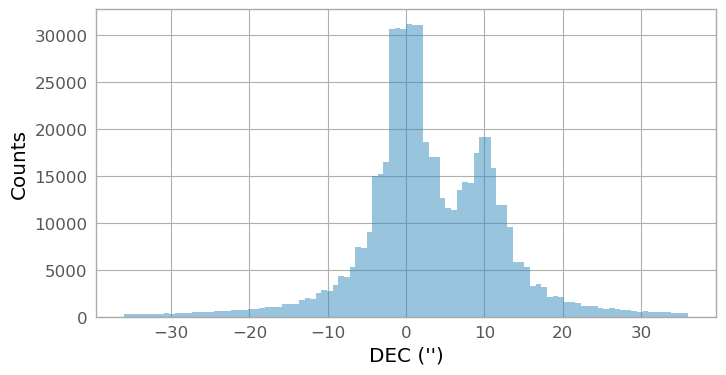

In [207]:
# study source separation (histogram of Dec positions) 
f = fits.open(evtfile_merged10)
data = f['EVENTS'].data
decVals = data['DEC']
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel("DEC ('')")
ax1.set_ylabel("Counts")
# create histogram
bh, bc, _ = ax1.hist(decVals[(decVals>-0.01) & (decVals<0.01)]*3600, bins=100, density=False, label="Histogram", alpha=0.5)

### <span style="color:blue">$\textbf{Exercise}$</span>:  
#### Repeat the previous exercise for a source separation of 5'' and extract spectra for all sources. Generate corrected ARFs for the sources by adjusting the parameters of the `sixte_arfgen` call above and use your favorite X-ray spectral analysis program to see how the spectral shape is affected.

In [210]:
# simputfile
simputfile5 = os.path.join(dir, f"{base_harder}_5.fits")
ra = 0.0
dec5 = 5.0/3600 #deg
Elow = 0.01 # to cover full range of ARF
Eup = 20  # to cover full range of ARF
Emin = 2
Emax = 10

# Command for creating the simput file
comm = [
    "simputfile",
    f"Simput={simputfile5}",
    "Src_Name=first",
    f"RA={ra}",
    f"Dec={dec5}",
    f"srcFlux={simput_flux_harder}",
    f"Elow={Elow}",
    f"Eup={Eup}",
    "NBins=1000",
    f"Emin={Emin}",
    f"Emax={Emax}",
    f"XSPECFile={xcm_harder}",
    "clobber=yes"
]

# Run the command with subprocess
try:
    print("Creating simput file...")
    subprocess.run(comm, check=True)
    print("Simput file created successfully.")
except subprocess.CalledProcessError as e:
    print(f"An error occurred while creating the simput file: {e}")

Creating simput file...
finished successfully!


		XSPEC version: 12.14.1
	Build Date/Time: Sun Oct 13 18:44:41 2024


!XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

!XSPEC12>method leven 10 0.01

!XSPEC12>abund wilm
 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).

!XSPEC12>xsect bcmc
 Cross Section Table set to bcmc:  Balucinska-Church and McCammon, 1998

!XSPEC12>cosmo 70 0 0.73

!XSPEC12>xset delta 0.01
Parameter delta values for fits will now be 0.01 * parValue

!XSPEC12>systematic 0

 The default systematic error for models is set to 0


!XSPEC12>model  phabs*pegpwrlw  ;              0.2      0.001          0          0     100000      1e+06  ;              1.5       0.01         -3         -2          9         10  ;                2      -0.01       -100       -100      1e+10      1

In [211]:
# Merge simput files
simputfile5 = os.path.join(dir, f"{base_harder}_5.fits")
simput_merged5 = os.path.join(dir, f"{base}_{base_harder}_5_merged.fits")
comm_merge = [
    "simputmerge",
    f"Infile1={simputfile}",
    f"Infile2={simputfile5}",
    f"Outfile={simput_merged5}",
    "clobber=yes",
    "FetchExtensions=yes"
]

# Run the merge command with subprocess
try:
    print("Merging original mcrab and newsrc_offset simput files...")
    subprocess.run(comm_merge, check=True)
    print("Simput files merged successfully.")
except subprocess.CalledProcessError as e:
    print(f"An error occurred while merging simput files: {e}")



Merging original mcrab and newsrc_offset simput files...

merging simput files ...
100%

cleaning up ...
finished successfully!

Simput files merged successfully.


In [212]:
xml = os.path.join(xmldir, "ld_wfi_ff_large.xml")
evtfile_merged5 = os.path.join(dir, f"sim_evt_{base}_{base_harder}_5_merged.fits")
expos = 5000

# Loop through factors and run the simulation for each flux factor
for factor in flux_ratio:
    
    comm = [
        "runsixt",
        f"XMLFile={xml}",
        "RA=0.",
        "Dec=0.",
        f"Simput={simput_merged5}",
        f"EvtFile={evtfile_merged5}",
        f"Exposure={expos}",
        "clobber=yes"
    ]
    
    try:
        print("Running 5 ks simulation with merged simput file...")
        result = subprocess.run(comm, check=True, capture_output=True, text=True)
        print("Simulation completed successfully.")
        print("Output:", result.stdout)
        if result.stderr:
            print("Warnings/Errors:", result.stderr)
    except subprocess.CalledProcessError as e:
        print(f"An error occurred during the simulation: {e}")
        print("Error details:", e.stderr)


Running 5 ks simulation with merged simput file...
Simulation completed successfully.
Output: SIXTE version 2.7.2
initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_v20230523.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

InconsistentKeywordValues: First channel differs between MATRIX (1) and EBOUNDS (0) extensions.

=== End of RMF validity check report ===

open Pha2Pi file '/Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pha2pi_v20230609.fits' ...
load source catalog from file '/Users/jessicaplanelles/sixte_tutorial/mcrab_hardersrc_5_merged.fits' ...
try to load all spectra ('/Users/jessicaplanelles/sixte_tutorial/mcrab_hardersrc_5_merged.fits[SPECTRUM,1]') into cache ...
open event file 'raw.fits' ...
open event file '/Users/jessicaplanelles/sixte_tutorial/sim

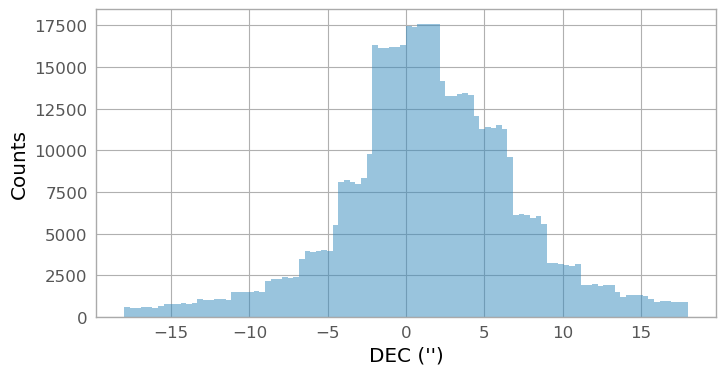

In [213]:
# study source separation (histogram of Dec positions) 
f = fits.open(evtfile_merged5)
data = f['EVENTS'].data
decVals = data['DEC']
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xlabel("DEC ('')")
ax1.set_ylabel("Counts")
# create histogram
bh, bc, _ = ax1.hist(decVals[(decVals>-0.005) & (decVals<0.005)]*3600, bins=100, density=False, label="Histogram", alpha=0.5)

In [214]:

radius = 5.  # arcseconds

for off in (5, 10):
    arfcorr = os.path.join(dir, f"arf_corrected_{off}.fits")
    regcircle = os.path.join(dir, f"circle_{off}.reg")
    offgrad = off / 3600.
    image_merged = os.path.join(dir, f"img_{base}_{base_harder}_{off}_merged.fits")
    evtfile_merged = os.path.join(dir, f"sim_evt_{base}_{base_harder}_{off}_merged.fits")

    # Extract image
    comm_img = [
        "imgev",
        f"EvtFile={evtfile_merged}",
        f"Image={image_merged}",
        "CoordinateSystem=0",
        "Projection=TAN",
        "NAXIS1=512",
        "NAXIS2=512",
        "CUNIT1=deg",
        "CUNIT2=deg",
        "CRVAL1=0",
        "CRVAL2=0",
        "CRPIX1=256.5",
        "CRPIX2=256.5",
        "CDELT1=-6.207043e-04",
        "CDELT2=6.207043e-04"
    ]
    
    try:
        print(f'Extracting image with src at {off}"')
        subprocess.run(comm_img, check=True, capture_output=True, text=True)
        print(f"Image extraction completed for offset {off}.")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred while extracting the image for offset {off}: {e}")
        print("Error details:", e.stderr)
    
    # Define region
    with open(regcircle, 'w') as fw:
        fw.write("fk5\n")
        fw.write(f'circle(0.,{offgrad},{radius}")')
        
    # Correct ARF
    comm_arf = [
        "sixte_arfgen",
        f"ARFCorr={arfcorr}",
        f"XMLFile={xml}",
        "PointingRA=0.0",
        "PointingDec=0.0",
        f"SourceRA=0.0",
        f"SourceDec={offgrad}",
        f"ImageFile={image_merged}",
        f"regfile={regcircle}"
    ]
    
    try:
        print(f'Correcting ARF for src at {off}"')
        subprocess.run(comm_arf, check=True, capture_output=True, text=True)
        print(f"ARF correction completed for offset {off}.")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred while correcting the ARF for offset {off}: {e}")
        print("Error details:", e.stderr)


Extracting image with src at 5"
Image extraction completed for offset 5.
Correcting ARF for src at 5"
ARF correction completed for offset 5.
Extracting image with src at 10"
Image extraction completed for offset 10.
Correcting ARF for src at 10"
ARF correction completed for offset 10.


In [225]:
radInDeg = radius / 3600.  # Convert 5" radius to degrees

for off in (5, 10):
    RAmin = 360. - radInDeg
    RAmax = 0. + radInDeg
    DECmin = off / 3600 - radInDeg
    DECmax = off / 3600 + radInDeg
    filt = f"(RA>{RAmin}|| RA<{RAmax}) && Dec>{DECmin} && Dec<{DECmax}"
    specfile = os.path.join(dir, f"{base_harder}_{off}_spec.fits")
    evtfile_merged = os.path.join(dir, f"sim_evt_{base}_{base_harder}_{off}_merged.fits")
    
    # Command for makespec
    comm = [
        "makespec",
        f"EvtFile={evtfile_merged}",
        f"Spectrum={specfile}",
        "clobber=yes",
        f"RSPPath={xmldir}",
        f"EventFilter={filt}"
    ]

    try:
        print(f'Extracting spectrum of source at {off}" offset...')
        result = subprocess.run(comm, check=True, capture_output=True, text=True)
        print(f"Spectrum extraction completed for offset {off}.")
        print("Output:", result.stdout)
        if result.stderr:
            print("Warnings/Errors:", result.stderr)
    except subprocess.CalledProcessError as e:
        print(f"An error occurred during spectrum extraction for offset {off}: {e}")
        print("Error details:", e.stderr)

Extracting spectrum of source at 5" offset...
Spectrum extraction completed for offset 5.
Output: initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf
The following problems have been identified! ***

=== Start of RMF validity check report ===

InconsistentKeywordValues: First channel differs between MATRIX (1) and EBOUNDS (0) extensions.

=== End of RMF validity check report ===

***SPII_read_key: Cannot find DETNAM keyword - setting it to UNKNOWN
***SPII_read_key: Cannot find EFFAREA keyword - setting it to 1.000000
calculate spectrum ...
store spectrum ...
cleaning up ...
finished successfully!


Extracting spectrum of source at 10" offset...
Spectrum extraction completed for offset 10.
Output: initialize ...

*** Warning in print_ftchkrmf_warning: RMF validity check failed for /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-w

In [223]:
for off in (5, 10):
    arfcorr = os.path.join(dir, f"arf_corrected_{off}.fits")
    specfile = os.path.join(dir, f"{base_harder}_{off}_spec.fits")
    
    with fits.open(specfile, 'update') as f:
        # Strip the path and ensure filename length for RESPFILE
        rmflong = f[1].header['RESPFILE']
        rmf = os.path.basename(rmflong)[:68]  # Trim to fit within 80-character limit
        f[1].header['RESPFILE'] = rmf
        
        # Trim ANCRFILE path as needed to fit 80-character limit
        arfcorr_basename = os.path.basename(arfcorr)[:68]
        f[1].header['ANCRFILE'] = arfcorr_basename

In [226]:
# Rebin spectrum
for off in (5, 10):
    specfile = os.path.join(dir, f"{base_harder}_{off}_spec.fits")
    rebin = os.path.join(dir, f"{base_harder}_{off}_spec.grp")
    comm = f"grppha infile={specfile} outfile={rebin} clobber=yes comm='group min 10 & exit'"
    
    try:
        print("Rebinning spectrum...")
        result = subprocess.run(comm, check=True, capture_output=True, text=True, shell=True)
        print("STDOUT:", result.stdout)
        print("STDERR:", result.stderr)
        
        if os.path.exists(rebin):
            print("Rebinning completed successfully.")
            print(f"Output file saved as: {rebin}")
        else:
            print("Error: The output file was not created.")
    except subprocess.CalledProcessError as e:
        print("Error in rebinning spectrum:")
        print("STDOUT:", e.stdout)
        print("STDERR:", e.stderr)

Rebinning spectrum...
STDOUT:  
  -------------------------
  MANDATORY KEYWORDS/VALUES
  -------------------------
  --------------------------------------------------------------------
  --------------------------------------------------------------------
  EXTNAME   - SPECTRUM        Name of this BINTABLE
  TELESCOP  - Athena          Mission/Satellite name
  INSTRUME  - WFI             Instrument/Detector
  FILTER    - NONE            Instrument filter in use
  EXPOSURE  - 5000.0          Integration time (in secs) of PHA data
  AREASCAL  - 1.0000          Area scaling factor
  BACKSCAL  - 1.0000          Background scaling factor
  BACKFILE  - NONE            Associated background file
  CORRSCAL  - 0.0000          Correlation scaling factor
  CORRFILE  - NONE            Associated correlation file
  RESPFILE  - /Users/jessicaplanelles/simput4/share/sixte/instrument...
  ANCRFILE  - /Users/jessicaplanelles/simput4/share/sixte/instrument...
  POISSERR  - TRUE            Whether Poi


1 spectrum  in use
 
Spectral Data File: /Users/jessicaplanelles/sixte_tutorial/hardersrc_5_spec.grp  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.872e+01 +/- 9.871e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-991
  Telescope: Athena Instrument: WFI  Channel Type: PI
  Exposure Time: 5000 sec
 Using fit statistic: chi
 Using Response (RMF) File            /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf for Source 1
 Using Auxiliary Response (ARF) File  /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_13rows_wo_filter_LDA_v20240209.arf

    14 channels (1-14) ignored in spectrum #     1

   608 channels (384-991) ignored in spectrum #     1


Model phabs<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   powe

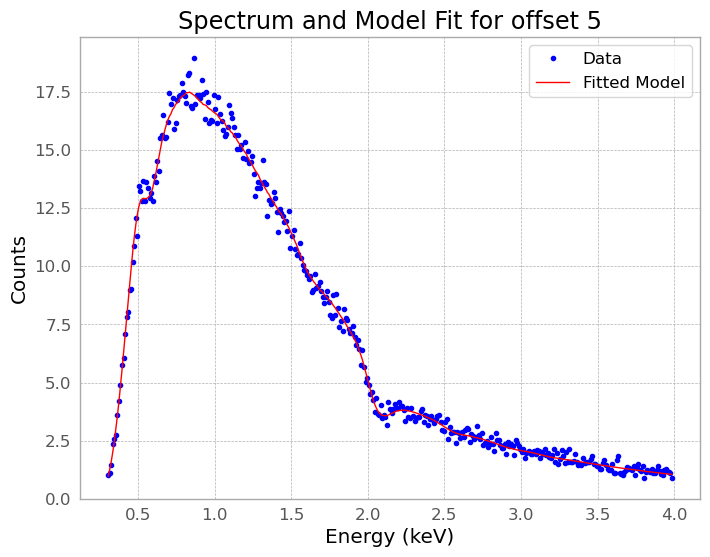


1 spectrum  in use
 
Spectral Data File: /Users/jessicaplanelles/sixte_tutorial/hardersrc_10_spec.grp  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.687e+01 +/- 7.331e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-978
  Telescope: Athena Instrument: WFI  Channel Type: PI
  Exposure Time: 5000 sec
 Using fit statistic: chi
 Using Response (RMF) File            /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_pirmf_v20230609.rmf for Source 1
 Using Auxiliary Response (ARF) File  /Users/jessicaplanelles/simput4/share/sixte/instruments/athena-wfi/wfi_wo_filter/athena_wfi_sixte_13rows_wo_filter_LDA_v20240209.arf

     9 channels (1-9) ignored in spectrum #     1

   600 channels (379-978) ignored in spectrum #     1


Model phabs<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   phabs      nH         10^22    1.00000      +/-  0.0          
   2    2   powe

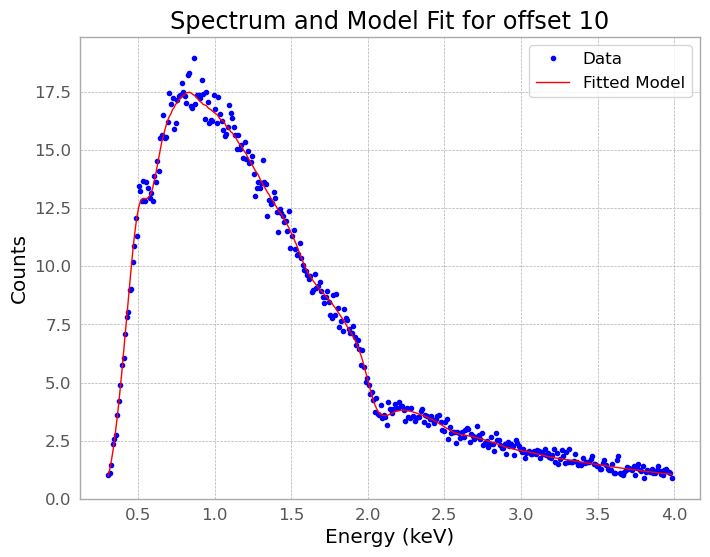

In [231]:
Gammas = dict()

# Fit spectra and plot variations
for off in (5, 10):
    rebin = os.path.join(dir, f"{base_harder}_{off}_spec.grp")
    Plot.device = '/null'  # Suppress external window
    AllData.clear()
    AllModels.clear()

    # Load the model and data
    s0 = Spectrum(rebin)
    s0.ignore("**-0.3")
    s0.ignore("4.0-**")
    m = Model("phabs*pow")

    # Perform the fit and store the Gamma index
    Fit.perform()
    Gammas[off] = m.powerlaw.PhoIndex.values[0]

    # Extract plot data from xspec
    x_data = Plot.x()
    y_data = Plot.y()
    y_model = Plot.model()
    
    plt.figure(figsize=(8, 6))
    plt.plot(x_data, y_data, 'o', label="Data", color='blue', markersize=3)
    plt.plot(x_data, y_model, '-', label="Fitted Model", color='red', linewidth=1)
    plt.xlabel("Energy (keV)")
    plt.ylabel("Counts")
    plt.title(f"Spectrum and Model Fit for offset {off}")
    plt.grid(True, which="both", linestyle="--", lw=0.5)
    plt.legend()
    plt.show()

    # Add delay to separate plots
    time.sleep(5)

In [232]:
Plot.device = '/null'
for off in (5, 10):
    print(f'Spectral Index for {off}" source: {Gammas[off]:.3f}')

Spectral Index for 5" source: 1.740
Spectral Index for 10" source: 1.536


### <span style="color:blue">$\textbf{Exercise}$</span>:  
#### In order to quantify the mixing of photons from both sources further, we can take a look at the diagnostic information contained in the event file. Specifically, use the FTOOL `fselect` and, using the row selection syntax, generate a new event file for one of the two sources by selecting the events in the region around the source. Determine the fraction of photons from the other source that “contaminate” the selection region by using the information in the `SRC_ID` column of the event file. For each event, this column contains information about the source in which it originated, in form of the ID of that source in the SIMPUT file.


In [233]:
import subprocess

# Define central source region parameters
evt0 =  os.path.join(dir, "sim_evt_0.fits")
radInDeg = 5. / 3600.
RAmin = 360. - radInDeg
RAmax = 0. + radInDeg
DECmin = 0. - radInDeg
DECmax = 0. + radInDeg

# Construct filter expression and command for central source region
filt = f"(RA>{RAmin} || RA<{RAmax}) && Dec>{DECmin} && Dec<{DECmax}"
comm = f"fselect infile={evtfile_merged5}+1 outfile={evt0} expr='{filt}' clobber=yes"

# Run the command
print("Selecting events for source at centre")
try:
    result = subprocess.run(comm, check=True, capture_output=True, text=True, shell=True)
    print("STDOUT:", result.stdout)
    print("STDERR:", result.stderr)
except subprocess.CalledProcessError as e:
    print("Error selecting central source events:")
    print("STDOUT:", e.stdout)
    print("STDERR:", e.stderr)

# Define 5" offset source region parameters
evt5 = "sim_evt_5.fits"
DECmin = 5. / 3600. - radInDeg
DECmax = 5. / 3600. + radInDeg

# Construct filter expression and command for 5" offset source region
filt = f"(RA>{RAmin} || RA<{RAmax}) && Dec>{DECmin} && Dec<{DECmax}"
comm = f"fselect infile={evtfile_merged5}+1 outfile={evt5} expr='{filt}' clobber=yes"

# Run the command
print("Selecting events for source at 5\" offset")
try:
    result = subprocess.run(comm, check=True, capture_output=True, text=True, shell=True)
    print("STDOUT:", result.stdout)
    print("STDERR:", result.stderr)
except subprocess.CalledProcessError as e:
    print("Error selecting offset source events:")
    print("STDOUT:", e.stdout)
    print("STDERR:", e.stderr)

    

Selecting events for source at centre
STDOUT: 
STDERR: 
Selecting events for source at 5" offset
STDOUT: 
STDERR: 


In [234]:
# Total counts (both sources)
f = fits.open(evtfile_merged5)
data = f['EVENTS'].data
print("Total number of photons in both sources (central & 5'' offset)=",data.shape[0])
f.close

# Counts from central source
f = fits.open(evt0)
data = f['EVENTS'].data
idVals = data['SRC_ID']
f.close
nph = len(idVals)
nph2 =len(idVals[idVals[:,0]==2][:,0])
print(f'SRC1 (central): Number of photons from src2 (5" offset) = {nph2} ({nph2/nph*100:.2f} %)')

# Counts from 5" offset source
f = fits.open(evt5)
data = f['EVENTS'].data
idVals = data['SRC_ID']
f.close
nph = len(idVals)
nph1 =len(idVals[idVals[:,0]==1][:,0])
print(f'SRC2 (5" offset): Number of photons from src1 (central) = {nph1} ({nph1/nph*100:.2f} %)')


Total number of photons in both sources (central & 5'' offset)= 643265
SRC1 (central): Number of photons from src2 (5" offset) = 62473 (21.34 %)
SRC2 (5" offset): Number of photons from src1 (central) = 132183 (54.26 %)
